In [1]:
import chess
import chess.pgn
from sklearn.linear_model import LinearRegression

In [4]:
PGN = "../madchess-v-viri.pgn"
# list of (phase, move) tuples
xs: "list[tuple[int, int]]" = []
# list of moves-left values
ys: "list[int]" = []
pawn_phase, knight_phase, bishop_phase, rook_phase, queen_phase = [1, 10, 10, 20, 40]

In [5]:
game_counter = 0
with open(PGN, "r") as pgn:
    while True:
        pos_counter = 0
        game = chess.pgn.read_game(pgn)
        if game is None:  # EOF
            break
        game_counter += 1
        nodes = game.mainline()
        for node in nodes:
            board = node.board()
            phase = 0
            phase += chess.popcount(board.pawns) * pawn_phase
            phase += chess.popcount(board.knights) * knight_phase
            phase += chess.popcount(board.bishops) * bishop_phase
            phase += chess.popcount(board.rooks) * rook_phase
            phase += chess.popcount(board.queens) * queen_phase
            xs.append((phase, board.ply()))
            pos_counter += 1
        for i in range(pos_counter):
            ys.append(pos_counter - i)
    assert len(xs) == len(ys), f"{len(xs) = }, {len(ys) = }"
print(f"Read {game_counter} games, {len(xs)} positions")

Read 5092 games, 631548 positions


In [15]:
# augment xs with features
xs_aug = [ [x[0], x[1], x[0] * x[1], x[0] ** 2, x[1] ** 2] for x in xs ]

In [17]:
# fit model
model = LinearRegression()
model.fit(xs, ys)
# write model
weights = model.coef_
intercept = model.intercept_
print(f"{weights = }")
print(f"{intercept = }")
loss = model.score(xs, ys)
print(f"{loss = }")

weights = array([ 0.18644759, -0.29377428])
intercept = 63.537016010492195
loss = 0.3777608306703464


In [19]:
# fit augmented model
model_aug = LinearRegression()
model_aug.fit(xs_aug, ys)
# write model
weights_aug = list(model_aug.coef_)
intercept_aug = model_aug.intercept_
print(f"{weights_aug = }")
print(f"{intercept_aug = }")
loss_aug = model_aug.score(xs_aug, ys)
print(f"{loss_aug = }")

weights_aug = [0.322629598871821, -0.7896912608560478, -0.001186089580333777, -0.0007018578808016818, 0.0023484585152976634]
intercept_aug = 88.18997739181435
loss_aug = 0.4045591316305568


In [20]:
# average model output over all positions
avg = sum(ys) / len(ys)
print(f"{avg = }")

avg = 68.53883156941357


In [23]:
1 / 30.0 * avg

2.2846277189804525

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
from matplotlib import cm
import numpy as np

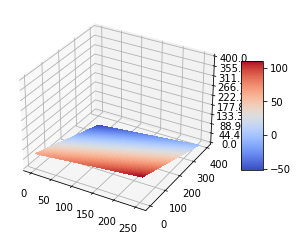

In [14]:
# plot a 3D surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0, 256, 1)
Y = np.arange(0, 400, 1)
X, Y = np.meshgrid(X, Y)
Z = weights[0] * X + weights[1] * Y + intercept
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(0, 400)
ax.zaxis.set_major_locator(LinearLocator(10))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()